# **Term Deposit Marketing**

**Background:**

This project is for a small startup focusing mainly on providing machine learning solutions in the European banking market. They work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

They are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, they are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal, they are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

**Data Description:**

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

**Attributes:**

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

y - has the client subscribed to a term deposit? (binary)

## **Importing Python packages and data**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm
import matplotlib.ticker as mtick
import matplotlib.style as style
import seaborn as sns
import scipy
from scipy.stats import randint, loguniform
import warnings
from google.colab import files
import time
style.use('ggplot')
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn import tree
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, f1_score
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
!pip install lazypredict
from lazypredict.Supervised import LazyClassifier

In [3]:
# necessary to read files into Colab
uploaded_files = files.upload()

Saving term-deposit-marketing-2020.csv to term-deposit-marketing-2020.csv


In [4]:
# Now, we can read the .csv file from desktop
df = pd.read_csv('term-deposit-marketing-2020.csv')

##**Exploratory Data Analysis**

In [6]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [7]:
df.isnull().values.any()

False

Great, looks like there are no missing values.

In [8]:
df.describe()

,age,balance,day,duration,campaign
count,40000.00,40000.00,40000.00,40000.00,40000.00
mean,40.54,1274.28,16.02,254.82,2.88
std,9.64,2903.77,8.28,259.37,3.24
min,19.00,-8019.00,1.00,0.00,1.00
25%,33.00,54.00,8.00,100.00,1.00
50%,39.00,407.00,17.00,175.00,2.00
75%,48.00,1319.00,21.00,313.00,3.00
max,95.00,102127.00,31.00,4918.00,63.00


The balance variable is quite skewed and has a large variance as seen below. We will take a closer look at these distributions later. This data should be scaled before modeling.

In [9]:
df.var()

age             92.96
balance    8431878.56
day             68.53
duration     67270.98
campaign        10.49
dtype: float64

In [10]:
print(df.groupby(['y']).size() / df.shape[0] * 100)

y
no    92.76
yes    7.24
dtype: float64


Only about 7% of customers have subscribed to a term deposit in this data set.  We will have to make sure that we stratify this data before modeling.  This will ensure a test set of approximately the same percentage.

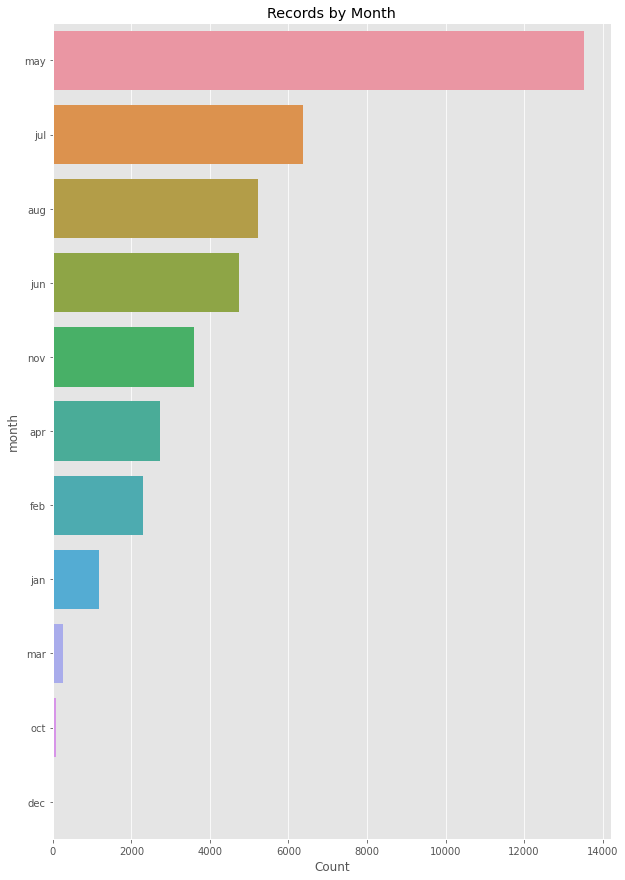

In [11]:
plt.figure(figsize=(10,15))

sns.countplot(y = 'month', data = df, order=df.month.value_counts().index)
plt.title('Records by Month')
plt.xlabel('Count')

plt.show()

This distribution plot of the month field is not what I expected at all.  Very little observations in March, October, December and none in September.  Now, three of these months are at the end of a quarter but so is June, which has a substantial amount of observations.  I suspect that this would skew results and provide little insight, so we will drop this variable from the data set.  

In [12]:
df = df.drop(['month'], axis = 1)

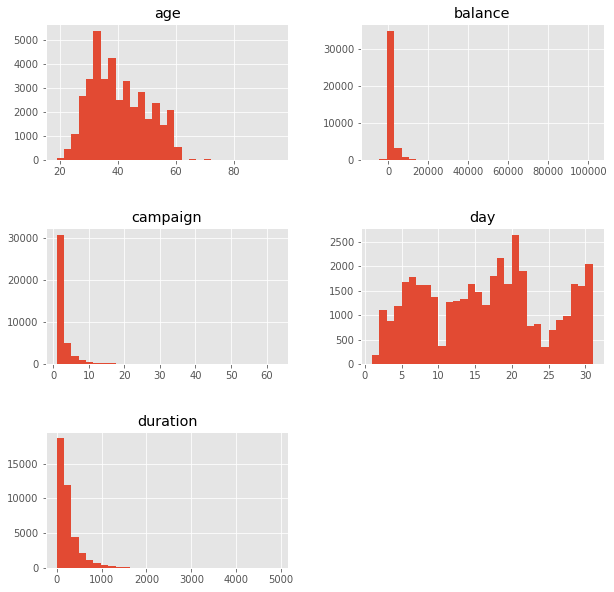

In [13]:
df.hist(figsize=(10,10), bins = 30)
plt.subplots_adjust(hspace=0.5);

These distributions are interesting as balance, duration and campaign are skewed to the right.  Day and age are interesting as age is almost symmetric centering around 35 years of age and day fluctuates throught the month.  These variables look relevant.

In [14]:
print(df.nunique())

age            70
job            12
marital         3
education       4
default         2
balance      6849
housing         2
loan            2
contact         3
day            31
duration     1535
campaign       48
y               2
dtype: int64


Unique values for variables help identify categorical, binary and continuous variables. The only strange one is the job variable but this makes sense. Below,we will check the distribution of seemingly categorical variables and check for unknown values.

In [15]:
df.job.value_counts()

blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64

In [16]:
df.marital.value_counts()

married     24386
single      10889
divorced     4725
Name: marital, dtype: int64

In [17]:
df.education.value_counts()

secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64

We have a very small amount of 'unknown' values for job and education variables.  Comparatively, we can remove these unknowns if it is less than 5% of the data set, which is standard.

In [18]:
df.contact.value_counts()

cellular     24914
unknown      12765
telephone     2321
Name: contact, dtype: int64

In [19]:
#Removing 'unknown' values from the data set.
contacts = df[df['contact'] == 'unknown']

print(contacts.groupby(['y']).size() / contacts.shape[0] * 100)

y
no    96.11
yes    3.89
dtype: float64


The contact field is strange as we are only differentiating between cellular and hose phones and the number for house phones is small.  Moreover, there are over 12,000 unknown entries.  This variable should be deleted from the data set as I do not suspect that it will provide much insight and if it does, it calls for a new experiment and survey. 

In [20]:
df = df.drop(['contact'], axis = 1)

In [21]:
#Removing 'unknown' values from the data set.
df = df[df['education'] != 'unknown']

In [22]:
df.job.value_counts()

blue-collar      8944
management       7977
technician       6638
admin            4335
services         3775
self-employed    1383
retired          1378
entrepreneur     1331
unemployed       1080
housemaid        1047
student           450
unknown           131
Name: job, dtype: int64

It looks like there are still some unknowns in the job variable as we did not catach all of them by removing unknowns from the education variable.  This means that we will remove 1662 rows from the data set of 40000 which is about 4 percent.  Because this is below 5%, this would be good practice and may help the predictive power of these features.

In [23]:
df = df[df['job'] != 'unknown']

In [24]:
print(df.nunique())

age            70
job            11
marital         3
education       3
default         2
balance      6685
housing         2
loan            2
day            31
duration     1522
campaign       47
y               2
dtype: int64


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38338 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        38338 non-null  int64 
 1   job        38338 non-null  object
 2   marital    38338 non-null  object
 3   education  38338 non-null  object
 4   default    38338 non-null  object
 5   balance    38338 non-null  int64 
 6   housing    38338 non-null  object
 7   loan       38338 non-null  object
 8   day        38338 non-null  int64 
 9   duration   38338 non-null  int64 
 10  campaign   38338 non-null  int64 
 11  y          38338 non-null  object
dtypes: int64(5), object(7)
memory usage: 3.8+ MB


That is more like it.  Time to wrangle some data.

##**Data Wrangling**

We will now convert the binary variables to integers, namely the target y.

In [26]:
df['default'] = df['default'].replace({'no':0, 'yes':1})
df['housing'] = df['housing'].replace({'no':0, 'yes':1})
df['loan'] = df['loan'].replace({'no':0, 'yes':1})
df['y'] = df['y'].replace({'no':0, 'yes':1})

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38338 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        38338 non-null  int64 
 1   job        38338 non-null  object
 2   marital    38338 non-null  object
 3   education  38338 non-null  object
 4   default    38338 non-null  int64 
 5   balance    38338 non-null  int64 
 6   housing    38338 non-null  int64 
 7   loan       38338 non-null  int64 
 8   day        38338 non-null  int64 
 9   duration   38338 non-null  int64 
 10  campaign   38338 non-null  int64 
 11  y          38338 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 3.8+ MB


After converting binary variables to integers, there are only three variables that need converted for modeling purposes.  I will use the LabelEncoder here as there are now 11 values for the job feature.  Using One-Hot encoding or even feature hashing would create way too many features.

In [28]:
gle = LabelEncoder()
genre_labels = gle.fit_transform(df['job'])
genre_mappings = {index: label for index, label in 
                  enumerate(gle.classes_)}
genre_mappings

{0: 'admin',
 1: 'blue-collar',
 2: 'entrepreneur',
 3: 'housemaid',
 4: 'management',
 5: 'retired',
 6: 'self-employed',
 7: 'services',
 8: 'student',
 9: 'technician',
 10: 'unemployed'}

Now, we can see a mapping scheme that has been created for each of the values has been mapped to a number.  We can simply create a new feature with these values and drop the subsequent values and refer to this scheme if necessary.

In [29]:
df['jobLabel'] = genre_labels

In [30]:
genre_labels_marital = gle.fit_transform(df['marital'])
genre_mappings_marital = {index: label for index, label in 
                  enumerate(gle.classes_)}
genre_mappings_marital

{0: 'divorced', 1: 'married', 2: 'single'}

In [31]:
genre_labels_ed = gle.fit_transform(df['education'])
genre_mappings_ed = {index: label for index, label in 
                  enumerate(gle.classes_)}
genre_mappings_ed

{0: 'primary', 1: 'secondary', 2: 'tertiary'}

In [32]:
df['maritalLabel'] = genre_labels_marital
df['edLabel'] = genre_labels_ed

In [33]:
df.head()

,age,job,marital,education,default,balance,housing,loan,day,duration,campaign,y,jobLabel,maritalLabel,edLabel
0,58,management,married,tertiary,0,2143,1,0,5,261,1,0,4,1,2
1,44,technician,single,secondary,0,29,1,0,5,151,1,0,9,2,1
2,33,entrepreneur,married,secondary,0,2,1,1,5,76,1,0,2,1,1
5,35,management,married,tertiary,0,231,1,0,5,139,1,0,4,1,2
6,28,management,single,tertiary,0,447,1,1,5,217,1,0,4,2,2


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38338 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           38338 non-null  int64 
 1   job           38338 non-null  object
 2   marital       38338 non-null  object
 3   education     38338 non-null  object
 4   default       38338 non-null  int64 
 5   balance       38338 non-null  int64 
 6   housing       38338 non-null  int64 
 7   loan          38338 non-null  int64 
 8   day           38338 non-null  int64 
 9   duration      38338 non-null  int64 
 10  campaign      38338 non-null  int64 
 11  y             38338 non-null  int64 
 12  jobLabel      38338 non-null  int64 
 13  maritalLabel  38338 non-null  int64 
 14  edLabel       38338 non-null  int64 
dtypes: int64(12), object(3)
memory usage: 4.7+ MB


Now, we will define our target (y), drop the remaining object features, define X and scale the values to get ready for modeling.

In [35]:
y = df['y']

df = df.drop(['job', 'marital', 'education', 'y'], axis = 1)

In [36]:
columns = df.columns
columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'jobLabel', 'maritalLabel', 'edLabel'],
      dtype='object')

This will allow us to add columns back to the dataframe but this data must be scaled first which is what we will do next.

In [37]:
#Here, we will scale the numerical data.

scaler = StandardScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns = columns)

In [38]:
df.head()

,age,default,balance,housing,loan,day,duration,campaign,jobLabel,maritalLabel,edLabel
0,1.84,-0.14,0.30,0.81,-0.46,-1.33,0.02,-0.59,-0.07,-0.25,1.32
1,0.38,-0.14,-0.43,0.81,-0.46,-1.33,-0.40,-0.59,1.46,1.39,-0.20
2,-0.77,-0.14,-0.44,0.81,2.15,-1.33,-0.69,-0.59,-0.69,-0.25,-0.20
3,-0.56,-0.14,-0.36,0.81,-0.46,-1.33,-0.45,-0.59,-0.07,-0.25,1.32
4,-1.29,-0.14,-0.28,0.81,2.15,-1.33,-0.15,-0.59,-0.07,1.39,1.32


Now, we are ready for modeling.

##**Modeling**

In [39]:
X = df

seed = 2346

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=seed)
print(X_train.shape[0] / X.shape[0])
print(X_test.shape[0] / X.shape[0])

0.7499869581094476
0.25001304189055246


Good, the training and test sets are in the percentages we want them.  I always like to check that.

In [40]:
clf = tree.DecisionTreeClassifier(max_depth = 7, criterion = 'gini', splitter = 'best')
modelT = clf.fit(X_train, y_train)
pred_y = modelT.predict(X_test)

test_precision = round(precision_score(y_test, pred_y), 4)
test_recall = round(recall_score(y_test, pred_y), 4)

print("Training accuracy: ", round(clf.score(X_train, y_train), 4))
print("Test accuracy: ", round(accuracy_score(y_test, pred_y), 4))
print('Test precision: {}, Test recall: {}'.format(test_precision, test_recall))

Training accuracy:  0.9398
Test accuracy:  0.9296
Test precision: 0.5297, Test recall: 0.2937


Wow! That looks pretty good but this is only one tree, so the predictive power of the tree by itself is poor.  The precision and recall numbers are also low but this is an optimistic result.  Let's see if the Lazy Classifier can help us decide on a machine learning function to use.

In [41]:
lazy = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = lazy.fit(X_train, X_test, y_train, y_test)

models

100%|██████████| 29/29 [01:55<00:00,  4.00s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.88,0.79,0.79,0.90,0.07
GaussianNB,0.93,0.68,0.68,0.92,0.05
QuadraticDiscriminantAnalysis,0.93,0.68,0.68,0.92,0.12
LinearDiscriminantAnalysis,0.93,0.67,0.67,0.92,0.18
DecisionTreeClassifier,0.90,0.65,0.65,0.90,0.20
ExtraTreeClassifier,0.90,0.64,0.64,0.90,0.06
LGBMClassifier,0.93,0.63,0.63,0.92,0.41
XGBClassifier,0.93,0.63,0.63,0.92,0.74
LabelPropagation,0.91,0.63,0.63,0.90,32.90


Now, we should conceptually think about what machine learning algoritm to use.  The Light Gradient Boosting Machine may be the best choice here as it is tuneable, a good selection for the number of observations under 50,000 and it is good with a large number of features since we have not explored feature elimination yet.  Nearest Centroid and Gaussian Naive-Bayes does not have a great deal of hyperparameters, the Extra Tree Classifier can only be used in ensemble methods and the Decision Tree is what we tried earlier and does not have good predictive power as well as being extremely sensitive to changes in the data. Below is my function for hyperparameter tuning that uses randomized search cross-validation.  We can set the number of folds later.

In [42]:
def hyperparameter_tune(base_model, parameters, n_iter, k, X = X_train, y = y_train):
    start_time = time.time()
    
    optimal_model = RandomizedSearchCV(base_model,
                            param_distributions=parameters,
                            n_iter=n_iter,
                            cv=k,
                            n_jobs=-1,
                            random_state=seed)
    
    optimal_model.fit(X, y)
    
    stop_time = time.time()

    scores = cross_val_score(optimal_model, X, y, cv=k, scoring="accuracy")
    
    print("Elapsed Time:", time.strftime("%H:%M:%S", time.gmtime(stop_time - start_time)))
    print("====================")
    print("Cross Val Mean: {:.3f}, Cross Val Stdev: {:.3f}".format(scores.mean(), scores.std()))
    print("Best Score: {:.3f}".format(optimal_model.best_score_))
    print("Best Parameters: {}".format(optimal_model.best_params_))
    
    return optimal_model.best_params_, optimal_model.best_score_

Now, we will define relevant hyperparameters for the LGBM classifier.

In [43]:
parameters = {
        'silent': [False],
        'max_depth': randint(3, 20),
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0, 3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'num_leaves': randint(15, 60),
        'reg_lambda': loguniform(0.1, 100),
        'n_estimators': randint(50, 300)
}

Next, we will fit our Light Gradient Boosting Machine Classifier (LGBM) on the training set.  Here, we will use the best hyperparameter values after 60 iterations which should put us inside of a 95% confidence interval that we have the best model and to put those hyperparameters into our model subsequently. 

In [44]:
ltgb = lgb.LGBMClassifier(learning_rate=0.01, n_estimators=100, max_depth=15,subsample=0.52,colsample_bytree=0.6,seed=seed, 
                    reg_lambda=2, min_child_weight = 0.5, num_leaves=40)

best_params, best_score = hyperparameter_tune(ltgb, parameters, 60, 5, X_train, y_train)

Elapsed Time: 00:00:10
Cross Val Mean: 0.932, Cross Val Stdev: 0.003
Best Score: 0.933
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 10.0, 'n_estimators': 77, 'num_leaves': 16, 'reg_lambda': 0.5689290960786398, 'silent': False, 'subsample': 0.6}


This was a really great score and we now have best parameters with 95% confidence.  Now, we should try the optimized model with a different random seed to see how it performs. 

In [45]:
ltgb_tuned = lgb.LGBMClassifier(learning_rate=0.1, n_estimators=77, max_depth=6, subsample=0.6,colsample_bytree=0.8,seed=1818, 
                    reg_lambda=0.5689290960786398, min_child_weight = 10, num_leaves=16)
ltgb_tuned.fit(X_train,y_train)
print(ltgb_tuned.score(X_train,y_train))
print(ltgb_tuned.score(X_test,y_test))

0.9394845755225542
0.9322900365153887


This is a really high accuracy on the training and test sets, the target has been stratified and the values are close to the cross-validation mean. Below is the confusion matrix.

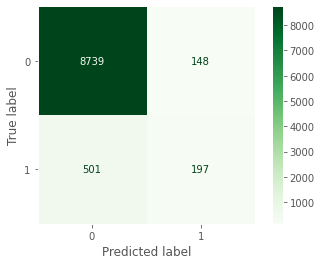

Accuracy of Light Gradient Boosting Machine: 93.22900365153886 

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      8887
           1       0.57      0.28      0.38       698

    accuracy                           0.93      9585
   macro avg       0.76      0.63      0.67      9585
weighted avg       0.92      0.93      0.92      9585



In [46]:
ltgb_predicted = ltgb_tuned.predict(X_test)

plot_confusion_matrix(ltgb_tuned, X_test, y_test, cmap = 'Greens')
plt.grid(False)
plt.show()

ltgb_acc_score = accuracy_score(y_test, ltgb_predicted)

print("Accuracy of Light Gradient Boosting Machine:",ltgb_acc_score*100,'\n')
print(classification_report(y_test,ltgb_predicted))

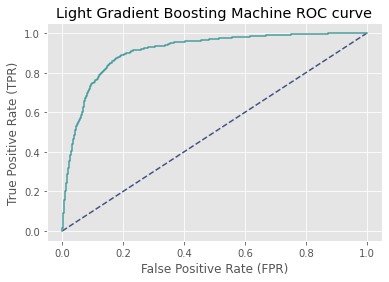

In [47]:
y_pred_proba = ltgb_tuned.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot([0,1],[0,1], color='#495084', linestyle='--')
plt.plot(fpr,tpr, label='ltgb', color='#479D9E')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Light Gradient Boosting Machine ROC curve')
plt.show()

In [48]:
roc = roc_auc_score(y_test,y_pred_proba)
print('ROC Score: {:.2f}'.format(roc))

ROC Score: 0.91


In [49]:
def plot_feature_importance(importance, names, model_type):

#Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

#Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

#Define size of bar plot
  plt.figure(figsize=(10,8))
#Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
  plt.title(model_type + ' Feature Importance')
  plt.xlabel('Feature Importance to Model')
  plt.ylabel('Features')

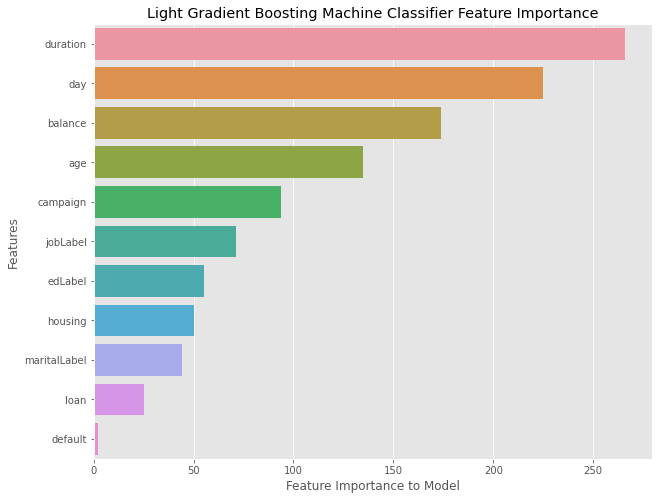

In [50]:
plot_feature_importance(ltgb_tuned.feature_importances_, X_train.columns,'Light Gradient Boosting Machine Classifier')

##**Conclusion**

The accuracy of the Light Gradient Boosting Machine model on this data set was very good at over 93% on the test data after 5-fold randomized search cross-validation and stratifying the data set which makes me suspect that overfitting did not occur.  This number is almost identical to the average cross-validation accuracy on the training set. I created a hyperparameter tuning function to capture the best parameters for the model.  The area under the ROC curve was 0.91 for this model. The Lazy Classifier was used to help identify the Light Gradient Boosting Machine function for this project.

Feature selection was performed during exploratory data analysis where the month feature did not have an even distribution of values.  The majority of observations were in the month of May and none were observed in September.  Additionally, contact was removed from the data set as there were a large number of unknown values and there was a very small distribution of customers who were contacted on their telephones as opposed to cellular.  I did not see how this would lend any insight especially since there were fewer customers that purchased a term deposit in the telephones class.  

The Light Gradient Boosting Machine model has an embedded feature importance function and the results were a little surprising.  Customers that have defaulted has little importance on the model in terms of subscribing to a term deposit.  However, the duration of the last call to the customer was considered to be the most important feature in this model.  The day of the month in which the customer was contacted also had large importance as well.  Usually, with most banking business problems, the balance of an account is a usually of great importance to a model.  Lastly, the age of the customer has importance as well. This model appears to be quite robust.  
     